Problem:

A robot is trying to navigate it's way out. In order to understand where it might have reached, it is using the GPS sensor. But sometimes the GPS measurements are noisy. In order to fix this noise, we can uses a CHVM to better estimate and locate the robot. In this model, the velocity and heading are kept constant. 

![image.png](attachment:image.png)

In [3]:
import numpy as np
%matplotlib inline
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from scipy.stats import norm
from sympy import Symbol, symbols, Matrix, sin, cos
from sympy import init_printing
init_printing(use_latex=True)

### Implementation of EKF Kalman Filter with Constant Heading Velocity Model (CHCV)       

In constant heading and velocity model, we assume that the  of the ego vehicle is moving with a constant heading and velocity. Thus, with time we don't update the heading and velocity value in the prediction step but we update the position of the ego vehicle.

### Extended Kalman Filter.

As we know, kalman filter works well with the linear dynamic systems, but the CHCV is a non linear model. In order to work on non linear models, Kalman filter approximates the gaussians coming out of the non-linear model. 


So, in EKF, the state and observation models need to be differentiable.

$\boldsymbol{x}_{k} = g(\boldsymbol{x}_{k-1}, \boldsymbol{u}_{k-1}) + \boldsymbol{w}_{k-1}$

$\boldsymbol{z}_{k} = h(\boldsymbol{x}_{k}) + \boldsymbol{v}_{k}$

Where $w_k$ and $v_k$ are the process and observation noises which are both assumed to be zero mean Multivariate Gaussian noises with covariance matrix $Q$ and $R$ respectively.

The function $g$ can be used to compute the predicted state from the previous estimate and similarly the function $h$ can be used to compute the predicted measurement from the predicted state. However, $g$ and $h$ cannot be applied to the covariance directly. Instead a matrix of partial derivatives (the Jacobian matrix) is computed.

At each time step, the Jacobian is evaluated with current predicted states. These matrices can be used in the Kalman filter equations. This process essentially linearizes the non-linear function around the current estimate.


The generic kalman filter looks like this.

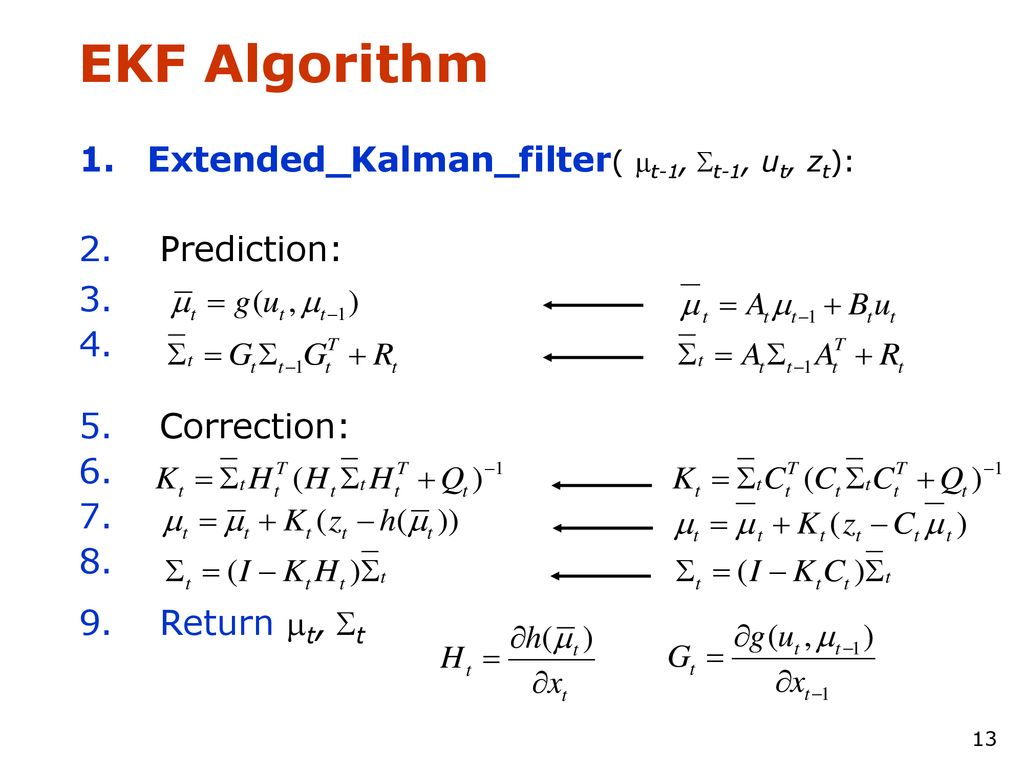

#### Prediction Step (Motion Model)

In the Extended Kalman Filter (EKF), the state matrix contains the parameters <u>**[Dx, Dy, V, H]**</u> of the robot.

Constant Heading, Constant Velocity Model

$$ x_k= \begin{bmatrix} x^{*} \\ y^{*} \\ \psi \\ v \end{bmatrix} = \begin{bmatrix} \text{Position X} \\ \text{Position Y} \\ \text{Heading} \\ \text{Velocity} \end{bmatrix} $$

$^{*}$=actually measured values in this implementation example!

The state matrix of ego robot:  [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


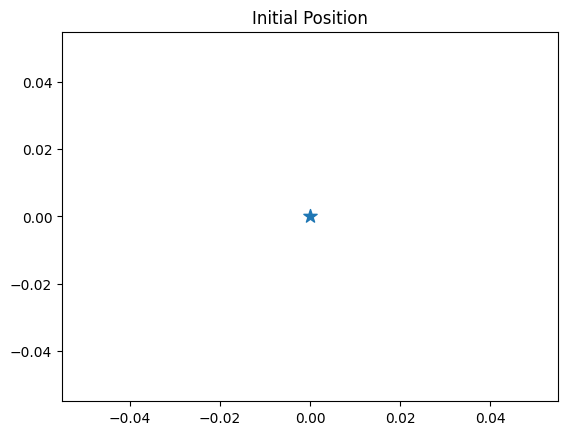

In [30]:
x = np.matrix([0.0, 0.0, 0.0, 0.0, 0.0, 0.0]).T
print("The state matrix of ego robot: ", x)
plt.scatter(float(x[0]), float(x[1]), s=100, marker='*')
plt.title("Initial Position")
numstates=4 # States

### Math development

In [31]:
vs, psis, dts, xs, ys, lats, lons = symbols('v \psi T x y lat lon')

gs = Matrix([[xs+vs*dts*cos(psis)],
             [ys+vs*dts*sin(psis)],
             [psis],
             [vs]])
state = Matrix([xs,ys,psis,vs])

In the prediction step, gs is the non linear Dynamic function which calculates the next possible state, given the current.

In [32]:
#the non linear dyamic function
gs

⎡T⋅v⋅cos(\psi) + x⎤
⎢                 ⎥
⎢T⋅v⋅sin(\psi) + y⎥
⎢                 ⎥
⎢      \psi       ⎥
⎢                 ⎥
⎣        v        ⎦

In [33]:
#the state vector x
state

⎡ x  ⎤
⎢    ⎥
⎢ y  ⎥
⎢    ⎥
⎢\psi⎥
⎢    ⎥
⎣ v  ⎦

### We need to calculate the Jacobian matrix which talks about the change of one state w.r.t to the other using differentiation.

![WhatsApp Image 2024-03-18 at 20.48.31.jpeg](<attachment:WhatsApp Image 2024-03-18 at 20.48.31.jpeg>)
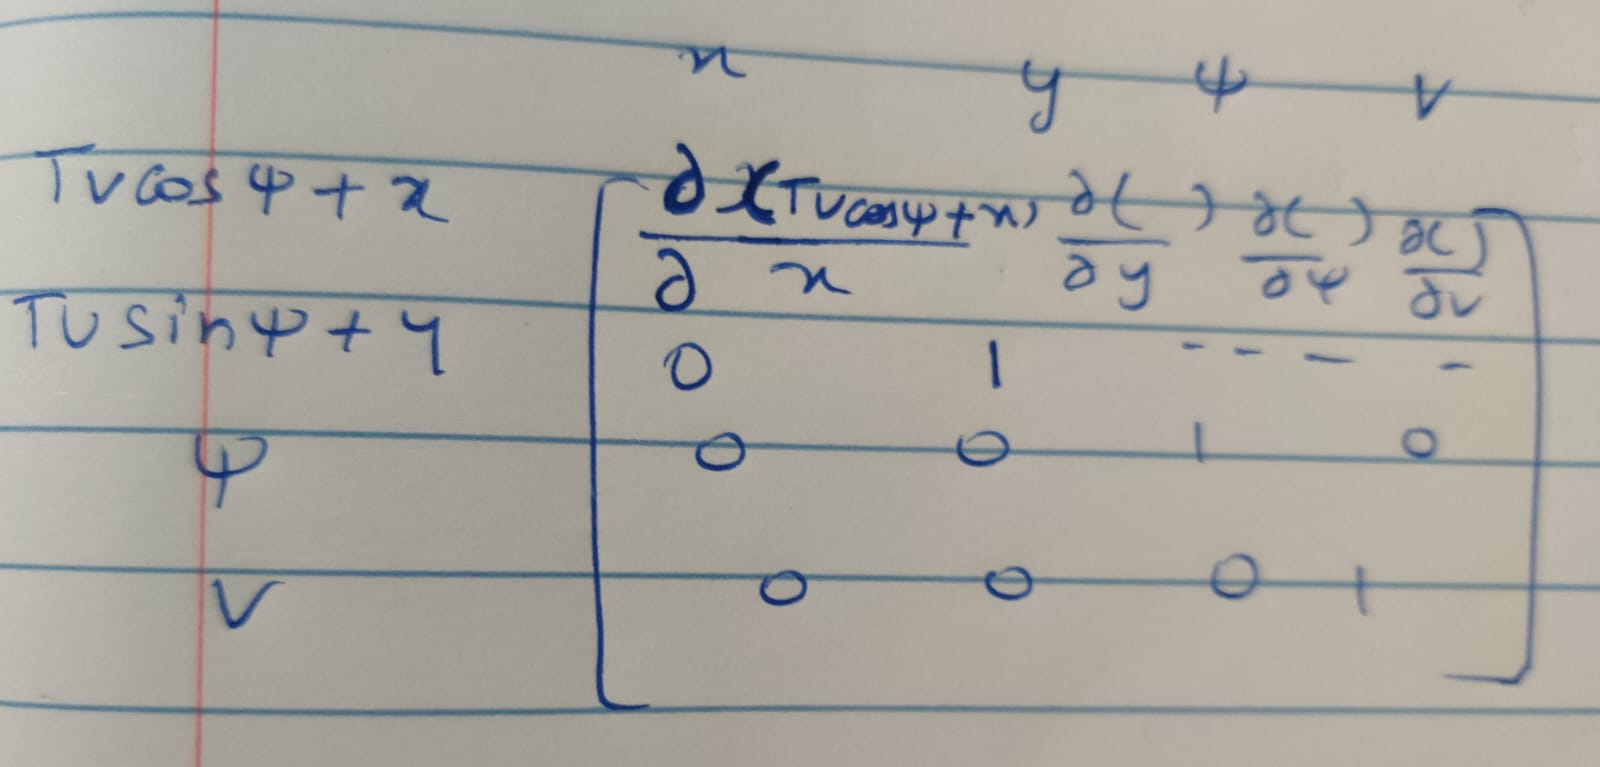

In [11]:
gs.jacobian(state)

⎡1  0  -T⋅v⋅sin(\psi)  T⋅cos(\psi)⎤
⎢                                 ⎥
⎢0  1  T⋅v⋅cos(\psi)   T⋅sin(\psi)⎥
⎢                                 ⎥
⎢0  0        1              0     ⎥
⎢                                 ⎥
⎣0  0        0              1     ⎦

The state matrix (X) contains the means of the parameters being tracked, while the uncertainty or standard deviation of these parameters are defined in the Error Covariance matrix (P).

$$
P = 
\begin{bmatrix}
\sigma_{dx_1}^2 & 0 & 0 & 0 \\
0 & \sigma_{dy_1}^2 & 0 & 0\\
0 & 0 & \sigma_{v}^2 & 0 \\
0 & 0 & 0 & \sigma_{heading}^2\\
\end{bmatrix}
$$

This is a general assumption of the KF where other than diagonal elements the matrix is filled with zeros. Yet, this is not followed in practice as if we know the prior understanding of relations between them, we can fill in thoses values. 

**Covariance:**

Covariance is a statistical measure, which define how change in one parameter shows up in the other. i.e., if X is a random variable which defines the students scores, and Y is a random variable which defines the no. of hours he studied, the covariance between the (X, Y) caluculatio based on the observed data would be positive.

Covariance can be calculated by,

$$
\text{cov}(X,Y) = E[(X - \mu_X)(Y - \mu_Y)]
$$





In order to find the covariance, we must calculate the mean of the X and Y variables, normalize the data and then find the expectation.

### Initial Uncertainity

In [12]:
P = np.eye(numstates)*1000.0
print("Initial Error Covariance: ", P)

Initial Error Covariance:  [[1000.    0.    0.    0.]
 [   0. 1000.    0.    0.]
 [   0.    0. 1000.    0.]
 [   0.    0.    0. 1000.]]


## Process Noise Covariance Matrix $Q$

"*The state uncertainty model models the disturbances which excite the linear system. Conceptually, it estimates how bad things can get when the system is run open loop for a given period of time.*" - Kelly, A. (1994). A 3D state space formulation of a navigation Kalman filter for autonomous vehicles, (May).

Because this depends on the `dt`, it has to be calculated in every filterstep.

In [14]:
#path = './../RaspberryPi-CarPC/TinkerDataLogger/DataLogs/2014/'
datafile = '2014-03-26-000-Data.csv'

date, \
time, \
millis, \
ax, \
ay, \
az, \
rollrate, \
pitchrate, \
yawrate, \
roll, \
pitch, \
yaw, \
speed, \
course, \
latitude, \
longitude, \
altitude, \
pdop, \
hdop, \
vdop, \
epe, \
fix, \
satellites_view, \
satellites_used, \
temp = np.loadtxt(datafile, delimiter=',', unpack=True,skiprows=1)

print('Read \'%s\' successfully.' % datafile)

# A course of 0° means the Car is traveling north bound
# and 90° means it is traveling east bound.
# In the Calculation following, East is Zero and North is 90°
# We need an offset.
course =(-course+90.0)

Read '2014-03-26-000-Data.csv' successfully.


In [15]:
dt = np.hstack([0.02, np.diff(millis)])/1000.0 # in s

#### Measurement Model h

Matrix $J_H$ is the Jacobian of the Measurement function $h$ with respect to the state. Function $h$ can be used to compute the predicted measurement from the predicted state.

If a GPS measurement is available, the following function maps the state to the measurement.


$$
hs = 
\begin{bmatrix}
x \\
y
\end{bmatrix}
$$

In [16]:
hs = Matrix([[xs],
             [ys]])
JHs=hs.jacobian(state)
JHs

⎡1  0  0  0⎤
⎢          ⎥
⎣0  1  0  0⎦

If no GPS measurement is available, simply set the corresponding values in $J_h$ to zero.

### Measure noise covariance R

In [17]:
varGPS = 6.0 # Standard Deviation of GPS Measurement
R = np.diag([varGPS**2.0, varGPS**2.0])

print("Measurement Noise Covariance Matrix R: ", R)

Measurement Noise Covariance Matrix R:  [[36.  0.]
 [ 0. 36.]]


In [19]:
I = np.eye(numstates)
print(I, I.shape)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]] (4, 4)


## Approx. Lat/Lon to Meters to check Location

In [22]:
RadiusEarth = 6378388.0 # m
arc= 2.0*np.pi*(RadiusEarth+altitude)/360.0 # m/°

dx = arc * np.cos(latitude*np.pi/180.0) * np.hstack((0.0, np.diff(longitude))) # in m
dy = arc * np.hstack((0.0, np.diff(latitude))) # in m

mx = np.cumsum(dx)
my = np.cumsum(dy)

ds = np.sqrt(dx**2+dy**2)

GPS=(ds!=0.0).astype('bool') # GPS Trigger for Kalman Filter

measurements = np.vstack((mx, my))
# Lenth of the measurement
m = measurements.shape[1]
print(measurements.shape)

(2, 10800)


Initial state

In [21]:
x = np.matrix([[mx[0], my[0], 0.5*np.pi, 0.0]]).T
print(x, x.shape)

[[0.        ]
 [0.        ]
 [1.57079633]
 [0.        ]] (4, 1)


In [23]:
# Preallocation for Plotting
x0, x1, x2, x3 = [], [], [], []
Zx, Zy = [], []
Px, Py, Pdx, Pdy = [], [], [], []
Kx, Ky, Kdx, Kdy = [], [], [], []

def savestates(x, Z, P, K):
    x0.append(float(x[0]))
    x1.append(float(x[1]))
    x2.append(float(x[2]))
    x3.append(float(x[3]))
    Zx.append(float(Z[0]))
    Zy.append(float(Z[1]))    
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Pdx.append(float(P[2,2]))
    Pdy.append(float(P[3,3]))
    Kx.append(float(K[0,0]))
    Ky.append(float(K[1,0]))
    Kdx.append(float(K[2,0]))
    Kdy.append(float(K[3,0]))

In [25]:
for filterstep in range(m):
    
    # Time Update (Prediction)
    # ========================
    # Project the state ahead
    # see "Dynamic Matrix"
    x[0] = x[0] + dt[filterstep]*x[3]*np.cos(x[2])
    x[1] = x[1] + dt[filterstep]*x[3]*np.sin(x[2])
    x[2] = (x[2]+ np.pi) % (2.0*np.pi) - np.pi
    x[3] = x[3]
    
    # Calculate the Jacobian of the Dynamic Matrix A
    # see "Calculate the Jacobian of the Dynamic Matrix with respect to the state vector"
    a13 = -dt[filterstep]*x[3]*np.sin(x[2])
    a14 = dt[filterstep]*np.cos(x[2])
    a23 = dt[filterstep]*x[3]*np.cos(x[2])
    a24 = dt[filterstep]*np.sin(x[2])
    JA = np.matrix([[1.0, 0.0, a13, a14],
                    [0.0, 1.0, a23, a24],
                    [0.0, 0.0, 1.0, 0.0],
                    [0.0, 0.0, 0.0, 1.0]])
    
    
    # Calculate the Process Noise Covariance Matrix
    sGPS     = 0.5*8.8*dt[filterstep]**2  # assume 8.8m/s2 as maximum acceleration
    sCourse  = 2.0*dt[filterstep] # assume 0.5rad/s as maximum turn rate
    sVelocity= 35.0*dt[filterstep] # assume 8.8m/s2 as maximum acceleration

    Q = np.diag([sGPS**2, sGPS**2, sCourse**2, sVelocity**2])
    
    # Project the error covariance ahead
    P = JA*P*JA.T + Q
    P = P.astype(float)
    # Measurement Update (Correction)
    # ===============================
    # Measurement Function
    hx = np.matrix([[float(x[0])],
                    [float(x[1])]])

    if GPS[filterstep]: # with 10Hz, every 5th step
        JH = np.matrix([[1.0, 0.0, 0.0, 0.0],
                        [0.0, 1.0, 0.0, 0.0]])
    else: # every other step
        JH = np.matrix([[0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0]])        
    JH_T = JH.T.astype(float)
    S = JH*P*JH.T + R
    K = (P*JH.T) * np.linalg.inv(S)

    # Update the estimate via
    Z = measurements[:,filterstep].reshape(JH.shape[0],1)
    y = Z - (hx)                         # Innovation or Residual
    x = x + (K*y)

    # Update the error covariance
    P = (I - (K*JH))*P

    # Save states for Plotting
    savestates(x, Z, P, K)

In [26]:
def plotP():
    fig = plt.figure(figsize=(16,9))
    plt.semilogy(range(m),Px, label='$x$')
    plt.step(range(m),Py, label='$y$')
    plt.step(range(m),Pdx, label='$\psi$')
    plt.step(range(m),Pdy, label='$v$')

    plt.xlabel('Filter Step')
    plt.ylabel('')
    plt.title('Uncertainty (Elements from Matrix $P$)')
    plt.legend(loc='best',prop={'size':22})

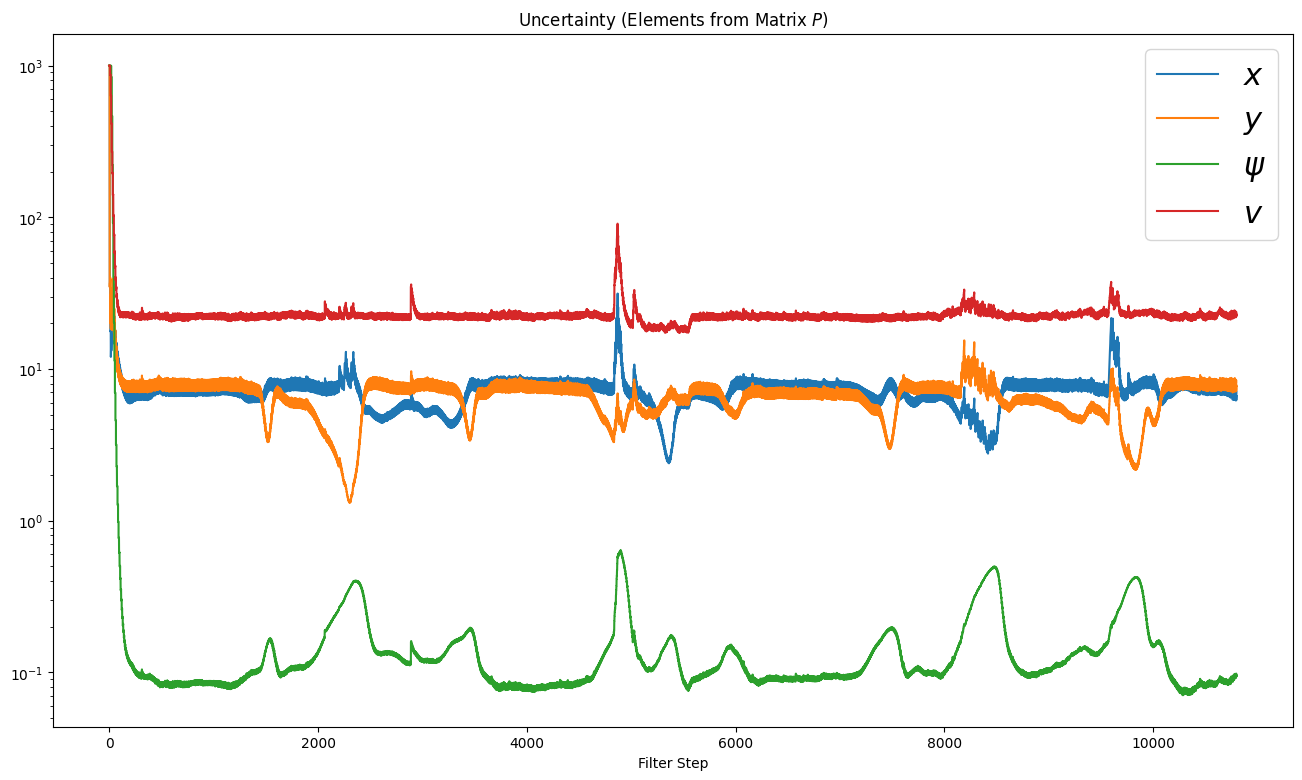

In [27]:
plotP()

In [28]:
def plotxydetails():
    fig = plt.figure(figsize=(12,9))

    plt.subplot(221)
    # EKF State
    #plt.quiver(x0,x1,np.cos(x2), np.sin(x2), color='#94C600', units='xy', width=0.05, scale=0.5)
    plt.plot(x0,x1, label='EKF Position', c='g', lw=5)

    # Measurements
    plt.scatter(mx[::5],my[::5], s=50, label='GPS Measurements', alpha=0.5, marker='+')
    #cbar=plt.colorbar(ticks=np.arange(20))
    #cbar.ax.set_ylabel(u'EPE', rotation=270)
    #cbar.ax.set_xlabel(u'm')

    plt.xlabel('X [m]')
    plt.xlim(70, 130)
    plt.ylabel('Y [m]')
    plt.ylim(140, 200)
    plt.title('Position')
    plt.legend(loc='best')


    plt.subplot(222)

    # EKF State
    #plt.quiver(x0,x1,np.cos(x2), np.sin(x2), color='#94C600', units='xy', width=0.05, scale=0.5)
    plt.plot(x0,x1, label='EKF Position', c='g', lw=5)

    # Measurements
    plt.scatter(mx[::5],my[::5], s=50, label='GPS Measurements', alpha=0.5, marker='+')
    #cbar=plt.colorbar(ticks=np.arange(20))
    #cbar.ax.set_ylabel(u'EPE', rotation=270)
    #cbar.ax.set_xlabel(u'm')

    plt.xlabel('X [m]')
    plt.xlim(160, 260)
    plt.ylabel('Y [m]')
    plt.ylim(110, 160)
    plt.title('Position')
    plt.legend(loc='best')

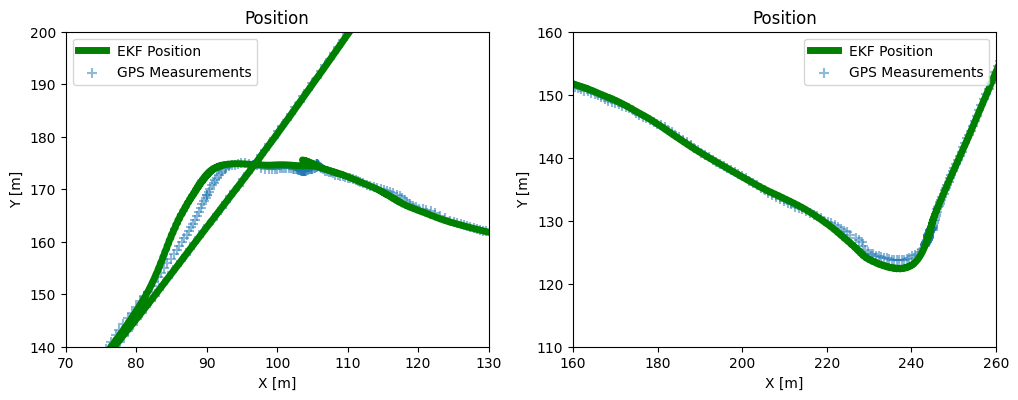

In [29]:
plotxydetails()